/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.5073 - loss: 0.6861 - val_accuracy: 0.6925 - val_loss: 0.6048
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.7171 - loss: 0.5808 - val_accuracy: 0.7500 - val_loss: 0.5509
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8818 - loss: 0.3131 - val_accuracy: 0.8125 - val_loss: 0.3990
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9465 - loss: 0.1442 - val_accuracy: 0.8150 - val_loss: 0.5327
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9830 - loss: 0.0549 - val_accuracy: 0.8375 - val_loss: 0.4756
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       203
           1       0.88      0.77      0.82       197

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       40

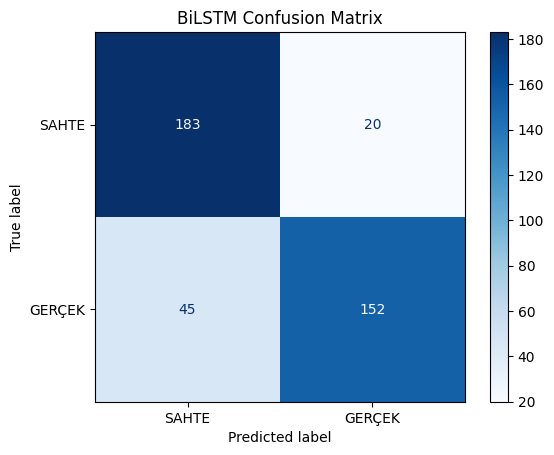

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. VERİYİ YÜKLE
df = pd.read_csv("/content/sonveriseti.csv")

# 2. GEREKLİ SÜTUNLARI AL
df = df[['translated_text', 'label']].copy()
df.rename(columns={'translated_text': 'review'}, inplace=True)

# 3. NaN temizliği
df.dropna(inplace=True)
df['label'] = df['label'].astype(int)

# 4. EĞİTİM / TEST AYIR
X = df['review'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. TOKENIZER ve PADDING
vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# 6. BiLSTM MODELİ
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 7. MODELİ EĞİT
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# 8. TAHMİN VE METRİKLER
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

# 9. CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["SAHTE", "GERÇEK"])
disp.plot(cmap=plt.cm.Blues)
plt.title("BiLSTM Confusion Matrix")
plt.show()


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def yorum_tahmin_et(yorum):
    # Yorumu sayıya çevir
    seq = tokenizer.texts_to_sequences([yorum])

    # Sabit uzunluğa pad et
    pad_seq = pad_sequences(seq, maxlen=max_len, padding='post')

    # Tahmin yap
    tahmin = model.predict(pad_seq)[0][0]

    # Ekrana yazdır
    if tahmin >= 0.5:
        print(f"✅ GERÇEK yorum ({tahmin:.2f})")
    else:
        print(f"❌ SAHTE yorum ({tahmin:.2f})")


In [16]:
yorumlar = [
    # SAHTE yorumlar
    "Ürün mükemmel, harika, şahane, mutlaka alın!",  # aşırı olumlu dolgu
    "Kesinlikle tavsiye ederim, herkes alsın bence.",  # yapay tavsiye
    "Harika! Harika! Harika!",  # tekrar ve abartı
    "Henüz kullanmadım ama iyi gibi duruyor.",  # deneyimsiz
    "Bu ürünü ikinci kez alıyorum çünkü çok güzel. (ilk kez almış)",  # tutarsız
    "Satıcı çok ilgiliydi ama ürünü daha açmadım.",  # içerik yok
    "Ürün güzel, kaliteli, sağlam, hoş. (detay yok)",  # kalıp cümle
    "Ürün çok iyi çalışıyor (yorum 5 farklı üründe aynı)",  # kopya yorum
    "1 dakikadır kullanıyorum, çok kaliteli bir ürün.",  # kısa deneyim
    "Gerçekten harika. Sadece harika.",  # içeriksiz ve boş

    # GERÇEK yorumlar
    "Kargo zamanında geldi ancak kutu biraz ezilmişti.",
    "2 haftadır kullanıyorum, pil performansı beklentimi aştı.",
    "Ürünün açıklamasında yazan renk farklı geldi ama iade ettim.",
    "Kablo uzunluğu yeterli değil ama ses kalitesi iyi.",
    "Ekran camında çizik vardı, garantiye gönderdim.",
    "Kullanımı kolay ama şarj süresi biraz kısa.",
    "Paketlemesi güzeldi ve hızlı teslimat yapıldı.",
    "Kutusundan kulaklık çıkmadı, firmayla iletişime geçtim.",
    "Malzeme kalitesi fiyatına göre iyi, memnun kaldım.",
    "Uzun süreli kullanımda biraz ısınıyor ama genel olarak iyi."
]


In [17]:
for yorum in yorumlar:
    print("📝 Yorum:", yorum)
    yorum_tahmin_et(yorum)  # Daha önce verdiğimiz tahmin fonksiyonu
    print("-" * 60)


📝 Yorum: Ürün mükemmel, harika, şahane, mutlaka alın!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
❌ SAHTE yorum (0.40)
------------------------------------------------------------
📝 Yorum: Kesinlikle tavsiye ederim, herkes alsın bence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
✅ GERÇEK yorum (0.78)
------------------------------------------------------------
📝 Yorum: Harika! Harika! Harika!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
✅ GERÇEK yorum (0.80)
------------------------------------------------------------
📝 Yorum: Henüz kullanmadım ama iyi gibi duruyor.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
✅ GERÇEK yorum (0.62)
------------------------------------------------------------
📝 Yorum: Bu ürünü ikinci kez alıyorum çünkü çok güzel. (ilk kez almış)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
❌ SAHTE yorum (0.33)
------------------------------------------------------------
📝 Yorum: Satıcı çok ilgiliydi ama ürünü daha açmadım.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
✅ GERÇEK yorum (0.50)
--------------------